In [1]:
import math
import numpy as np


## Working with Lucas Asset Prices, lognormal walk

Using https://llorracc.github.io/LucasAssetPrice/#PLognormGro (2023-03-15)

If utility is CRRA:

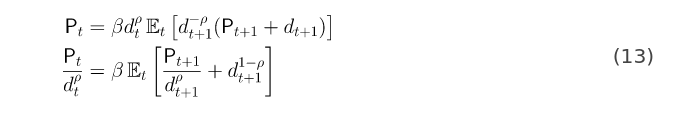


Now assume dividends follow a lognormal random walk:

$$\frac{d_{t+1}}{d_t} = \Gamma \phi_t =  e^\gamma \phi_t, \phi_t \sim e^{\mathcal{N}(-\sigma^2_d / 2, \sigma^2_d)}$$


Online LucasAssetPrice notes (13) :
$$P_t = \beta d^\rho_t \mathbb{E}_t \left[ d^{-\rho}_{t+1} \left( P_{t+1} + d_{t+1} \right) \right]$$

Implies:

$$\frac{P_t}{d_t} = \beta d^{\rho - 1}_t \mathbb{E}_t \left[ d^{1-\rho}_{t+1} \left( \frac{P_{t+1}}{d_{t+1}} + 1 \right) \right]$$

$$\frac{P_t}{d_t} = \beta d^{\rho - 1}_t \mathbb{E}_t \left[ (\Gamma \phi_t d_{t})^{1-\rho} \left( \frac{P_{t+1}}{d_{t+1}} + 1 \right) \right]$$

Assuming $\mathbf{r} = \frac{P_t}{d_t}$ and substituting in on both sides:

$$\mathbf{r} = \beta d^{\rho - 1}_t \mathbb{E}_t \left[ (\Gamma \phi_t d_{t})^{1-\rho} \left( \mathbf{r} + 1 \right) \right]$$


Notice the $d_t$ terms on the RHS cancel out, and the only stochastic element is $\phi_t$:

$$\mathbf{r} = ( \mathbf{r} + 1 ) \Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi_t  \right]$$

$$\mathbf{r} = \frac{\Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]}{1 -  \Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]}$$

We require $\mathbf{r}$ to be positive, implying conditions on $\Gamma$, $\phi$, and $\beta$:

$$0 < \frac{\Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]}{1 -  \Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]}$$

The top of the RHS ($\Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]$) will always be positive. So we are really interested in the denominator:

$$\Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right] < 1$$

I'm calling this expression on the LHS the **"subjective return"** provisionally. Why? Because it is the risk-aversion and discount factor adjusted expected growth rate of the risky asset (tree). If this value were greater than 1, then the price of the tree would be infinite. (If it were below 0, the price would be negatively infinite). Between 0 and 1, this means trees have a finite price.

$\Gamma = e^{\gamma}$, and...

$\mathbb{E}_t \left[ \phi^{1-\rho}_t  \right] = e^{((1 - \rho)^2 - (1 - \rho))\frac{\sigma^2_d}{2}} = e^{(\rho - 1)\rho\sigma^2_d/2} = e^{-(1 - \rho)\rho\sigma^2_d/2}$. Substitute in.

$$\beta e^{(1-\rho)\gamma} e^{-(1 - \rho)\rho\sigma^2_d/2} < 1$$

$$\beta e^{(1 - \rho)(\gamma - \rho\sigma^2_d/2)} < 1$$

$$\mathbf{r} = \frac{\beta e^{(1 - \rho)(\gamma - \rho\sigma^2_d/2)}}{1 - \beta e^{(1 - \rho)(\gamma - \rho\sigma^2_d/2)}}$$


$$\mathbf{r} = \frac{\beta }{e^{(\rho - 1)(\gamma - \rho\sigma^2_d/2)} - \beta}$$

In [2]:
import numpy as np

def subjective_return(gamma, sigma_d, rho, beta):
    return beta * np.exp((1 - rho) * (gamma - rho * sigma_d ** 2 / 2))

def price_dividend_ratio(gamma, sigma_d, rho, beta, check = True):
    sr = subjective_return(gamma, sigma_d, rho, beta)
    
    if check:
        print('subjective_return: ' + str(sr))
    
    return sr / (1 - sr)

## Working from real data

Does our base model calibration work with the impatience condition?

$$\Gamma^{1-\rho} \beta \mathbb{E}_t \left[ \phi^{1-\rho}_t  \right] < 1$$

We have the target mean and standard deviation of the (daily) price process $\mu_P$ and $\sigma_P$.

In [3]:
sp500_mu = 1.000628
sp500_st = 0.011988

And a daily $\beta$:

In [4]:
beta_quarterly = 0.96
days_per_quarter = 90
beta_daily = beta_quarterly ** (1 / days_per_quarter) # 0.999

The price dividend ratio is constant, so $\Gamma = \mu_P = e^\gamma$ and $\sigma_\phi = \frac{\sigma_P}{\sqrt{\Gamma}}$.

Suppose zero risk ($\sigma_d = 0$). Then impatience condition is $\Gamma ^ {1 - \rho} \beta < 1$

This is _decreasing_ in $\rho$, which is good. More risk aversion means _less_ patience is needed to satisfy the requirement.

In [5]:
Gamma = sp500_mu # Phi in Buffer Stock paper
gamma = np.log(Gamma)

In [6]:
rho = 2

sp500_mu ** (1 - rho) * beta_daily

0.9989192038738972

The tricky part is: $\mathbb{E}_t \left[ \phi^{1-\rho}_t  \right]$ given $\sigma_\phi$ (which is not the same as $\sigma_d$, the standard deviation of the underlying normal distribution.)

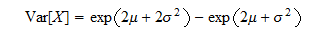

Recall that $\phi_t \sim e^{\mathcal{N}(-\sigma^2_d / 2, \sigma^2_d)}$. I.e. $\mu_d = - \sigma^2_d / 2$


$$\text{Var}[\phi_t] = \sigma^2_\phi = \exp(2 \mu_d + 2 \sigma_d ^{2}) - \exp(2\mu_d +\sigma_d ^{2})  = \exp(\sigma_d ^{2}) - 1$$

Which implies:

$$\log ( \sigma^2_\phi + 1) = \sigma^2_d$$

Recall that $\phi^p_t \sim e^{\mathcal{N}(-p \sigma^2_d / 2, p^2 \sigma^2_d)}$. From this we get:

$$\mathbb{E}_t \left[ \phi^{1-\rho}_t  \right] = e^{-(1 - \rho)\rho\sigma^2_d/2} = e^{-(1 - \rho)\rho\log ( \sigma^2_\phi + 1)/2} = (\sigma^2_\phi + 1)^{(\rho - 1)\rho /2}$$

Which means the impatience condition "at the level of" the lognormal shock is:

$$ \beta \mu_P^{1-\rho} (\sigma^2_\phi + 1)^{(\rho - 1)\rho /2} < 1$$

In [7]:
sigma_phi = sp500_st
sigma_d = math.sqrt(np.log(sigma_phi ** 2 + 1))

In [8]:
def subjective_return_exp(Gamma, beta, sigma_phi, rho):
    return Gamma ** (1 - rho) * beta * (sigma_phi ** 2 + 1) ** ((rho - 1) * rho / 2)

subjective_return_exp(Gamma, beta_daily, sigma_phi, rho)

0.9990627606943687

In [9]:
subjective_return(gamma, sigma_d, rho, beta_daily)

0.9990627606943687

This is the same as the 'subjective return_exp' computed above, as expected.

This corresponds to a price/dividend ratio.

In [10]:
price_dividend_ratio(gamma, sigma_d, rho, beta_daily)

subjective_return: 0.9990627606943687


1065.9633614292893

Note that there is a valid convex range of valid $\rho$.

In [11]:
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)

y = [rate_of_return(gamma, sigma_d, rho_x, beta_daily, check = False) for rho_x in x]

plt.plot(x,y)

plt.plot(x,[0] * 100, '--')
plt.xlabel("rho")
plt.ylabel("P_t / d_t")

NameError: name 'rate_of_return' is not defined

In [ ]:
price_dividend_ratio(gamma, sigma_d, rho, beta)

### Changing time scales

What happens if we change time scales?
In other words, we have been working with daily growth rates ($\beta$, $\Gamma$, etc.).
What happens if we look at quarterly growth rates?

Consider a scaling factor $z$ -- how many 'days' we want to combine together in the analysis. (This could be fractional if we want to scale down to hours or minutes.)

The scaled discount factors and dividend growth rate are $\beta^z$ and $\Gamma^z$ respectively.
The lognormal shock is multiplicatively applied, so the scaled shock is $\phi_t^z$.

This gets us to a scaled version of the impatience condition and subjective return:

$$(\Gamma^z)^{1-\rho} \beta^z \mathbb{E}_t \left[ (\phi^z_t)^{1-\rho}  \right] < 1$$

The tricky part is once again the expectation over the dividend shock.

Recall that $\phi^p_t \sim e^{\mathcal{N}(-p \sigma^2_d / 2, p^2 \sigma^2_d)}$ and that for a lognormal ranodm variable $X$, 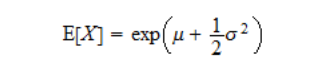. From this we get:

$$\mathbb{E}_t \left[ (\phi^z_t)^{1-\rho}  \right] = \mathbb{E}_t \left[ \phi_t^{z(1-\rho)}  \right] = \text{exp}[- z (1 - \rho) \sigma^2_d/2 + z^2(1 - \rho)^2 \sigma^2_d /2] = (\sigma^2_\phi + 1)^{z (-1 + \rho + z(\rho^2 -2 \rho + 1)/2)}$$



$$= e^{-(1 - \rho)\rho\log ( \sigma^2_\phi + 1)/2} = (\sigma^2_\phi + 1)^{(\rho - 1)\rho /2}$$


In [ ]:
z = 10
rho = 2

subjective_return_exp(Gamma ** z, beta ** z, sigma_phi, rho)

In [ ]:
## NOT WORKING.

def scaled_rate_of_return(scale, gamma, sigma, rho, beta):
    return rate_of_return(gamma * scale, scale * sigma, rho, beta ** scale)

In [ ]:
scaled_rate_of_return(90, gamma, sigma_d, rho, beta)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,360, 200)

y = [scaled_rate_of_return(scale, gamma, sigma_d, rho, beta) for scale in x]

plt.plot(x, y)
plt.plot(x, [0] * 200, '--')

plt.xlabel('time scale')
plt.ylabel('r')

In [ ]:
((1 - 0.96) / 0.96)

## Questions


Given that the returns on the risky asset are not just a constant times the dividend, but rather:
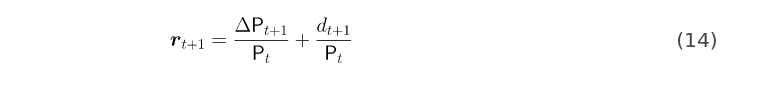

Are the returns lognormally distributed?

(Hypothesis: if $\mathbf{r} is small, then the returns are farther from a lognormal distribution, so this might trigger 'strange' expectations more...)

### Troubling musings about lognormal distributions and temporal scale

It would be nice if 'subjective return' and the 'impatience condition' were invariant to time scales.

But I am having trouble proving that. Because...compounded log normal distributions of mean 1 don't have mean 1? Can that be?

Recall that $\phi^p_t \sim e^{\mathcal{N}(-p \sigma^2_d / 2, p^2 \sigma^2_d)}$


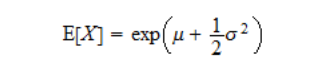

$$E[\phi^p] = \text{exp}[-p \sigma^2 / 2 + p^2 \sigma^2 / 2] = \text{exp}[p (p - 1) \sigma^2 / 2 ]$$

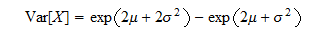

$\text{Var}[\phi^p] = \text{exp}[2 (- p \sigma^2)/2 + 2 (p^2 \sigma^2)] - \text{exp}[2 (-p \sigma^2 / 2) + (p^2 \sigma^2)]$

$= \text{exp}[2 \sigma^2 (p^2 - p /2)] - \text{exp}[(p^2 -p)  \sigma^2]$


##### Strange idea: risk aversion adjusting with time scale?


A quarterly $u_q$ CRRA utility function with a quarterly risk aversion rate $\rho_q$

$$u_q(c) = \frac{c^{1 - \rho_q}}{1 - \rho_q}$$

Suppose we want to construct an equivalent daily CRRA utility function $u_d$ where there are $r$ (for f**r**equency) days per quarter.

We assume the agent consumes $\frac{c}{r}$ each of $r$ days.

$$\frac{c^{1 - \rho_q}}{1 - \rho_q} = u_q(c) \approx r u_d \left( \frac{c}{r} \right) = r \frac{\left( \frac{c}{r}\right) ^{1 - \rho_d}  }{1 - \rho_d}$$

Attempting to simplify to establish a relationship between $\rho_q = 1 - o_q$ and $\rho_d = 1 - o_d$:

$$c^{1 - \rho_q} (1 - \rho_d) =  r \left( \frac{c}{r}\right) ^{1 - \rho_d}  (1 - \rho_q)$$

$$c^{1 - \rho_q} (1 - \rho_d) =  \frac{r}{r ^{1 - \rho_d}} c ^{1 - \rho_d}  (1 - \rho_q)$$

$$c^{o_q} o_d =  \frac{r}{r ^ {o_d}} c ^ {o_d}  o_q$$

$$ o_d \frac{r ^ {o_d}}{r} \frac{1}{c ^ {o_d}}=     o_q \frac{1}{c^{o_q}}$$


$$ (1 - \rho_d) \frac{r ^ {1 - \rho_d}}{r} \frac{1}{c ^ {1 - \rho_d}} \approx (1 - \rho_q) \frac{1}{c^{1 - \rho_q}}$$